---
# I. Installs & Imports

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~ Required Installs ~~~~~~~~~~~~~~~~~~~~~~~ #
!pip install torch --index-url https://download.pytorch.org/whl/cu121
!pip install torchvision
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow keras flask dash plotly shap
!pip install lightgbm catboost tqdm
!pip install --upgrade jupyter ipywidgets
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

import os
import zipfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import soft_sensor_lib
from datetime import datetime
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_absolute_error,
    r2_score,
    make_scorer,
)
from lightgbm import LGBMRegressor
from tqdm.auto import tqdm
# from catboost import CatBoostRegressor
# from catboost.sklearn import CatBoostRegressor
from catboost import CatBoostRegressor as _CatBoostRegressor
from sklearn.base import BaseEstimator, RegressorMixin

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # run on GPU
print(f"\nUsing device: {device}")

Looking in indexes: https://download.pytorch.org/whl/cu121

Using device: cuda


---
# II. Exploratory Data Analysis & Reconstruction (Quality Prediction in a Mining Process)

This section conducts Exploratory Data Analysis for the Quality Prediction in a Mining Process dataset that can be found at:
    https://www.kaggle.com/datasets/edumagalhaes/quality-prediction-in-a-mining-process

## 1. Loading Dataset, Datetime Conversion and Indexing

In [ ]:
from soft_sensor_lib import SoftSensorPipeline
# Unzip dataset only if needed
if not os.path.exists("./datasets/quality_prediction_in_a_mining_process.csv"):
    with zipfile.ZipFile("./datasets/quality_prediction_in_a_mining_process.zip", 'r') as zip_ref:
        zip_ref.extractall("./datasets")

# Load dataset
path = "./datasets/quality_prediction_in_a_mining_process.csv"

# Datetime Conversion and Indexing
df_mining = SoftSensorPipeline.load_csv_with_date(path)

# Display Dataset Head
print('df_mining ', df_mining.shape, ':', sep='')
with pd.option_context('display.max_columns', None):
    display(df_mining.head())

df_mining (737453, 23):


,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,250.576,295.096,306.4,250.225,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,250.862,295.096,306.4,250.137,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,250.313,295.096,306.4,251.345,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,250.049,295.096,306.4,250.422,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,249.895,295.096,306.4,249.983,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31


## 2. Dataset Summary and Descriptive Statistics

In [3]:
print("========= Dataset Summary =========")
print(df_mining.info())

========= Dataset Summary =========
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 737453 entries, 2017-03-10 01:00:00 to 2017-09-09 23:00:00
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   % Iron Feed                   737453 non-null  float64
 1   % Silica Feed                 737453 non-null  float64
 2   Starch Flow                   737453 non-null  float64
 3   Amina Flow                    737453 non-null  float64
 4   Ore Pulp Flow                 737453 non-null  float64
 5   Ore Pulp pH                   737453 non-null  float64
 6   Ore Pulp Density              737453 non-null  float64
 7   Flotation Column 01 Air Flow  737453 non-null  float64
 8   Flotation Column 02 Air Flow  737453 non-null  float64
 9   Flotation Column 03 Air Flow  737453 non-null  float64
 10  Flotation Column 04 Air Flow  737453 non-null  float64
 11  Flotation Column 05 Air Flow  7374

In [4]:
print("====== Descriptive Statistics ======")
with pd.option_context('display.max_columns', None):
    display(df_mining.describe())

====== Descriptive Statistics ======


,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
count,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000
mean,56.294739,14.651716,2869.140569,488.144697,397.578372,9.767639,1.680380,280.151856,277.159965,281.082397,299.447794,299.917814,292.071485,290.754856,520.244823,522.649555,531.352662,420.320973,425.251706,429.941018,421.021231,65.050068,2.326763
std,5.157744,6.807439,1215.203734,91.230534,9.699785,0.387007,0.069249,29.621288,30.149357,28.558268,2.572538,3.636579,30.217804,28.670105,131.014924,128.165050,150.842164,91.794432,84.535822,89.862225,84.891491,1.118645,1.125554
min,42.740000,1.310000,0.002026,241.669000,376.249000,8.753340,1.519820,175.510000,175.156000,176.469000,292.195000,286.295000,189.928000,185.962000,149.218000,210.752000,126.255000,162.201000,166.991000,155.841000,175.349000,62.050000,0.600000
25%,52.670000,8.940000,2076.320000,431.796000,394.264000,9.527360,1.647310,250.281000,250.457000,250.855000,298.262566,298.068000,262.541000,256.302000,416.978000,441.883000,411.325000,356.679000,357.653000,358.497000,356.772000,64.370000,1.440000
50%,56.080000,13.850000,3018.430000,504.393000,399.249000,9.798100,1.697600,299.344000,296.223000,298.696000,299.805000,299.887120,299.477000,299.011000,491.878000,495.956000,494.318000,411.974000,408.773000,424.664575,411.065000,65.210000,2.000000
75%,59.720000,19.600000,3727.730000,553.257000,402.968000,10.038000,1.728330,300.149000,300.690000,300.382000,300.638000,301.791137,303.061000,301.904000,594.114000,595.464000,601.249000,485.549000,484.329000,492.684000,476.465000,65.860000,3.010000
max,65.780000,33.400000,6300.230000,739.538000,418.641000,10.808100,1.853250,373.871000,375.992000,364.346000,305.871000,310.270000,370.910000,371.593000,862.274000,828.919000,886.822000,680.359000,675.644000,698.861000,659.902000,68.010000,5.530000


## 3. Assess Completeness of every 1hr Block: Add padding for incomplete hours (rows ≠ 180)

In [ ]:
print("========= Missisng Values =========")
with pd.option_context('display.max_columns', None):
    display(df_mining.isna().sum().to_frame().T)

print("========= Index Counts =========")
idx_counts = df_mining.index.value_counts().sort_index()
display(idx_counts.to_frame().T)

print("========= Missing Indices (rows ≠ 180) =========")
missing = idx_counts[idx_counts != 180]
display(missing.to_frame().T)

df_mining = SoftSensorPipeline.pad_incomplete_hour_blocks(df_mining)

if len(df_mining.index.value_counts().loc[lambda x: x != 180]) == 0:
    print('\n✅ Missing rows have been handled correctly. New df_mining.shape:', df_mining.shape)
else:
    print('\n⚠️ Error: Dataset still has missing rows. df_mining.shape:', df_mining.shape)

========= Missisng Values =========


,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


========= Index Counts =========


date,2017-03-10 01:00:00,2017-03-10 02:00:00,2017-03-10 03:00:00,2017-03-10 04:00:00,2017-03-10 05:00:00,2017-03-10 06:00:00,2017-03-10 07:00:00,2017-03-10 08:00:00,2017-03-10 09:00:00,2017-03-10 10:00:00,...,2017-09-09 14:00:00,2017-09-09 15:00:00,2017-09-09 16:00:00,2017-09-09 17:00:00,2017-09-09 18:00:00,2017-09-09 19:00:00,2017-09-09 20:00:00,2017-09-09 21:00:00,2017-09-09 22:00:00,2017-09-09 23:00:00
count,174,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180


========= Missing Indices (rows ≠ 180) =========


date,2017-03-10 01:00:00,2017-04-10 00:00:00
count,174,179



✅ Missing rows have been handled correctly. New df_mining.shape: (737460, 23)


## 4. Continuity Assesment (Missing hour ranges)

In [6]:
idx_hours = df_mining.index.sort_values().unique()
expected_hours = pd.date_range(idx_hours.min(), idx_hours.max(), freq='h')
missing_hours = expected_hours.difference(idx_hours)

if not missing_hours.empty:
    s = missing_hours.to_series()
    groups = (s.diff() > pd.Timedelta(hours=1)).cumsum()
    ranges = s.groupby(groups).agg(start='min', end='max', count='size')
    print("\nMissing hour ranges:")
    display(ranges)


Missing hour ranges:


,start,end,count
0,2017-03-16 06:00:00,2017-03-29 11:00:00,318


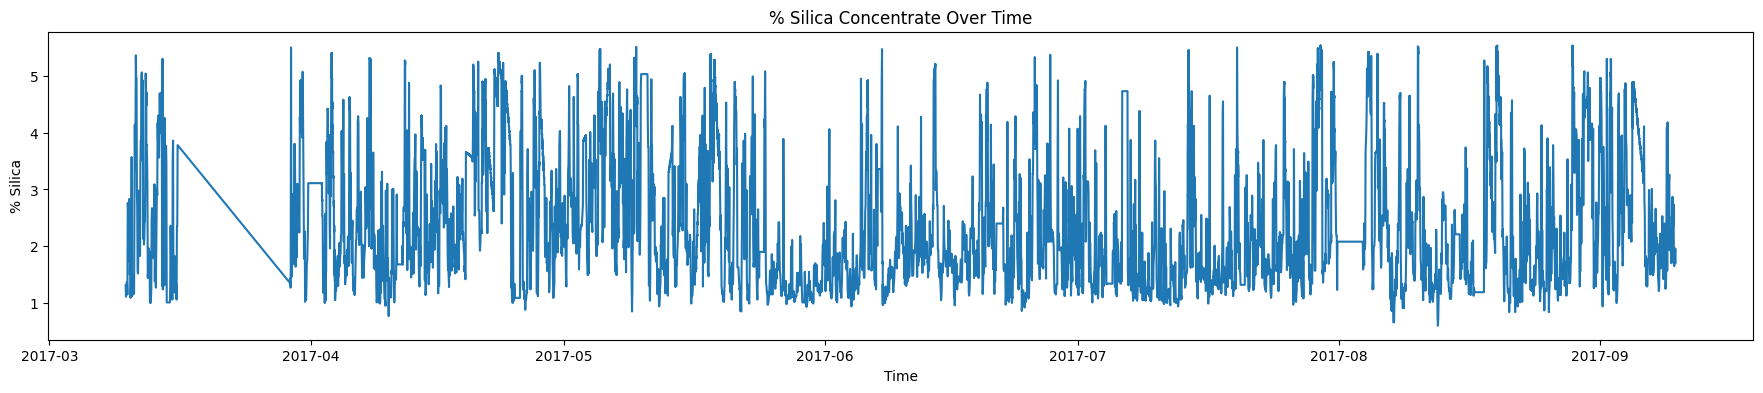

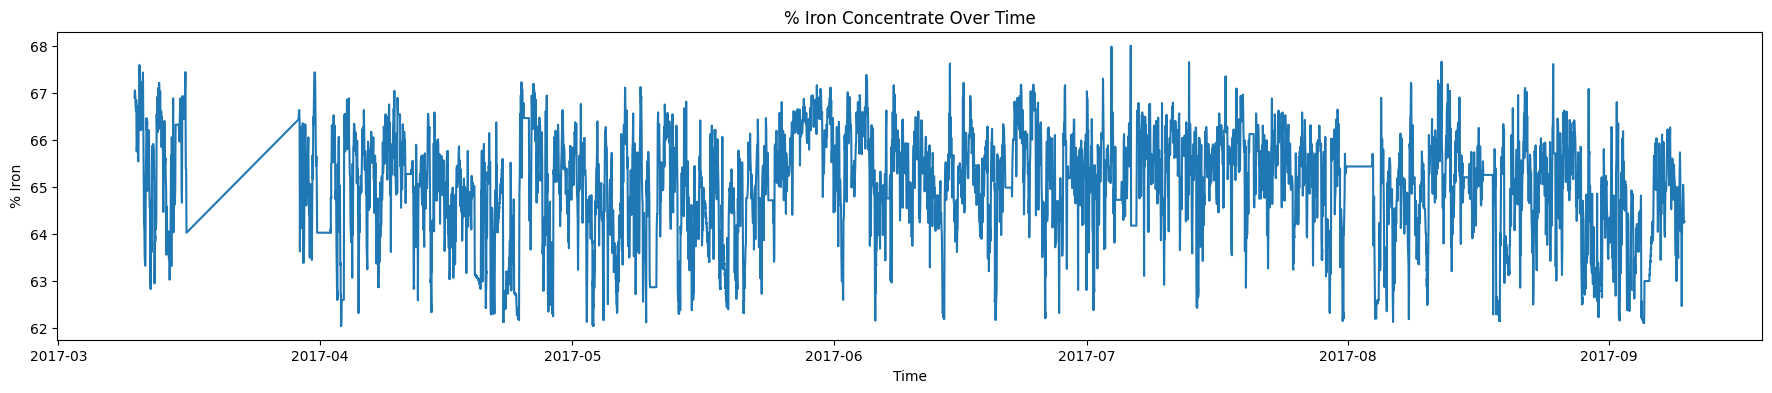

In [7]:
########### Visualize Missing Hour Range ###########
silica_over_time = df_mining['% Silica Concentrate']
plt.figure(figsize=(22,4))
plt.plot(silica_over_time.index, silica_over_time)
plt.title('% Silica Concentrate Over Time')
plt.xlabel('Time')
plt.ylabel('% Silica')
plt.show()

iron_over_time = df_mining['% Iron Concentrate']
plt.figure(figsize=(22,4))
plt.plot(iron_over_time.index, iron_over_time)
plt.title('% Iron Concentrate Over Time')
plt.xlabel('Time')
plt.ylabel('% Iron')
plt.show()

## 5. Reconstruct Timestamps for Continuous 20s and 1min Resolution Dataframes (no missing hours)

In [ ]:
df_20s, df_1min = SoftSensorPipeline.resample_dataframes(df_mining)

# Display resampled dataframes
with pd.option_context('display.max_columns', None):
    print('df_20s ', df_20s.shape, ':', sep='')
    display(df_20s)
    
    print('\ndf_1min ', df_1min.shape, ':', sep='')
    display(df_1min)

df_20s (794700, 23):


,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:00:00,55.20,16.98,3019.53,557.434,395.713000,10.06640,1.74000,249.214,253.235,250.576,295.096,306.400,250.225,250.8840,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
2017-03-10 01:00:20,55.20,16.98,3047.36,568.665,397.939000,10.06890,1.74000,249.917,254.487,250.049,295.096,306.400,250.422,251.1470,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
2017-03-10 01:00:40,55.20,16.98,3033.69,558.167,400.254000,10.06970,1.74000,250.203,252.136,249.895,295.096,306.400,249.983,248.9280,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31
2017-03-10 01:01:00,55.20,16.98,3193.07,596.588,399.507000,10.12170,1.74565,250.345,246.050,248.599,295.096,306.400,254.213,250.4880,457.171,381.078,447.533,457.598,462.853,429.902,395.663,66.91,1.31
2017-03-10 01:01:20,55.20,16.98,3079.10,564.697,396.533000,10.07050,1.74000,250.730,248.906,249.521,295.096,306.400,250.356,251.8730,444.384,443.269,460.449,439.920,451.588,433.539,425.458,66.91,1.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 23:58:20,49.75,23.20,1164.12,468.019,384.801000,9.61497,1.65310,300.355,292.865,298.625,298.717,297.395,362.464,308.1150,413.754,514.143,881.323,378.969,500.100,374.354,441.182,64.27,1.71
2017-09-09 23:58:40,49.75,23.20,3140.83,442.035,377.329286,9.61246,1.65466,297.070,302.897,299.707,301.535,302.507,358.209,355.2490,371.959,528.292,881.470,400.075,509.598,436.062,406.169,64.27,1.71
2017-09-09 23:59:00,49.75,23.20,3351.67,457.396,383.806000,9.62300,1.65668,299.268,296.670,302.990,300.185,296.825,344.677,306.7086,395.800,486.057,882.199,413.897,506.747,401.170,396.617,64.27,1.71



df_1min (264900, 23):


,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:00:00,55.20,16.98,3033.526667,561.422000,397.968667,10.068333,1.740000,249.778000,253.286000,250.173333,295.096000,306.400000,250.210000,250.319667,454.092667,448.009000,439.447333,447.812667,478.754667,442.580667,458.897333,66.91,1.31
2017-03-10 01:01:00,55.20,16.98,3133.320000,575.917333,396.313333,10.087833,1.741883,250.462667,249.052667,249.067333,295.096000,306.400000,251.839667,251.946000,449.246667,422.972667,453.429333,442.948667,452.663000,436.005333,417.457333,66.91,1.31
2017-03-10 01:02:00,55.20,16.98,3147.593333,560.221333,394.804667,10.073000,1.740000,249.895000,252.312000,248.745000,295.096000,306.400000,248.848000,250.788667,446.118667,472.835000,460.469333,451.455333,444.921333,456.468667,453.781333,66.91,1.31
2017-03-10 01:03:00,55.20,16.98,3150.910000,563.314000,395.820333,10.072700,1.740000,249.323667,250.393000,250.744667,295.096000,306.400000,249.961000,248.979333,455.444333,430.997333,451.029667,453.344333,470.495000,445.903333,470.448667,66.91,1.31
2017-03-10 01:04:00,55.20,16.98,3473.763333,563.090333,393.799000,10.077933,1.740000,249.551000,251.176667,250.444667,295.096000,306.400000,249.558333,249.550667,438.878000,421.046333,438.098667,461.381000,479.312000,466.212667,470.940333,66.91,1.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 23:55:00,49.75,23.20,2806.093333,458.414667,385.657333,9.618350,1.654330,301.258000,304.429333,301.355000,300.653333,302.042667,354.626667,312.407333,401.856000,544.387333,881.265000,417.711667,484.265000,344.557000,358.246333,64.27,1.71
2017-09-09 23:56:00,49.75,23.20,2705.773333,469.490000,381.697000,9.620110,1.653930,302.417000,298.622000,299.887000,299.826000,298.789000,350.136333,301.185000,392.335000,530.782333,870.522333,424.584000,486.970000,456.613333,386.959333,64.27,1.71
2017-09-09 23:57:00,49.75,23.20,2698.383333,471.658667,385.001667,9.620220,1.653517,303.006333,302.687333,299.379000,299.852333,299.931667,335.469000,258.758000,400.854667,411.544667,868.005000,418.877667,502.453333,385.129000,425.453000,64.27,1.71


## 6. Compare 20s vs 1min Descriptive Statistics

In [9]:
with pd.option_context('display.max_columns', None):
    print("====== df_20s Statistics ======")
    display(df_20s.describe())
    print("NaN count:")
    display(df_20s.isna().sum().to_frame().T)

    print("\n====== df_1min Statistics ======")
    display(df_1min.describe())
    print("NaN count:")
    display(df_1min.isna().sum().to_frame().T)

====== df_20s Statistics ======


,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
count,737460.000000,737460.000000,737460.000000,737460.000000,737460.000000,737460.000000,737460.000000,737460.000000,737460.000000,737460.000000,737460.000000,737460.000000,737460.000000,737460.000000,737460.000000,737460.00000,737460.000000,737460.000000,737460.000000,737460.000000,737460.000000,737460.000000,737460.000000
mean,56.294730,14.651733,2869.141657,488.144983,397.578307,9.767642,1.680380,280.151564,277.159672,281.082091,299.447752,299.917876,292.071088,290.754463,520.244351,522.64937,531.352127,420.321189,425.252041,429.941619,421.021776,65.050084,2.326754
std,5.157721,6.807410,1215.198645,91.230297,9.699763,0.387007,0.069249,29.621299,30.149365,28.558306,2.572560,3.636617,30.217935,28.670253,131.014482,128.16452,150.841622,91.794023,84.535493,89.862011,84.891275,1.118652,1.125553
min,42.740000,1.310000,0.002026,241.669000,376.249000,8.753340,1.519820,175.510000,175.156000,176.469000,292.195000,286.295000,189.928000,185.962000,149.218000,210.75200,126.255000,162.201000,166.991000,155.841000,175.349000,62.050000,0.600000
25%,52.670000,8.940000,2076.320000,431.796750,394.263000,9.527360,1.647310,250.281000,250.457000,250.855000,298.262353,298.068010,262.474250,256.290750,416.978000,441.88400,411.326000,356.680000,357.654750,358.497750,356.772000,64.370000,1.440000
50%,56.080000,13.850000,3018.440000,504.394000,399.248714,9.798100,1.697600,299.344000,296.223000,298.696000,299.804990,299.887280,299.477000,299.011000,491.877000,495.95550,494.317000,411.975000,408.775000,424.666000,411.067000,65.210000,2.000000
75%,59.720000,19.600000,3727.722500,553.256000,402.968000,10.038000,1.728330,300.149000,300.690000,300.382000,300.638000,301.791647,303.061000,301.904000,594.113000,595.46400,601.249000,485.548250,484.329000,492.686000,476.466250,65.860000,3.010000
max,65.780000,33.400000,6300.230000,739.538000,418.641000,10.808100,1.853250,373.871000,375.992000,364.346000,305.871000,310.270000,370.910000,371.593000,862.274000,828.91900,886.822000,680.359000,675.644000,698.861000,659.902000,68.010000,5.530000


NaN count:


,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,57240,57240,57240,57240,57240,57240,57240,57240,57240,57240,57240,57240,57240,57240,57240,57240,57240,57240,57240,57240,57240,57240,57240



====== df_1min Statistics ======


,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
count,245820.000000,245820.000000,245820.000000,245820.000000,245820.000000,245820.000000,245820.000000,245820.000000,245820.000000,245820.000000,245820.000000,245820.000000,245820.000000,245820.000000,245820.000000,245820.000000,245820.000000,245820.000000,245820.000000,245820.000000,245820.000000,245820.000000,245820.000000
mean,56.294730,14.651733,2869.141657,488.144983,397.578307,9.767642,1.680380,280.151564,277.159672,281.082091,299.447752,299.917876,292.071088,290.754463,520.244351,522.649370,531.352127,420.321189,425.252041,429.941619,421.021776,65.050084,2.326754
std,5.157728,6.807419,1139.005235,89.653817,9.271543,0.386145,0.068520,29.585554,29.835665,28.512739,2.486759,3.487819,29.880087,27.975203,128.795679,125.192738,148.330710,87.244695,81.503747,83.213622,80.843959,1.118604,1.125487
min,42.740000,1.310000,0.317815,241.699632,376.302577,8.753370,1.519832,175.752108,175.971531,176.471917,292.774049,286.969954,192.333667,186.074077,149.599000,211.389000,126.400047,162.335222,167.165240,162.029308,176.293000,62.050000,0.600000
25%,52.670000,8.940000,2088.325000,432.358333,395.720667,9.528382,1.647540,250.237333,250.331917,250.544333,298.780890,298.623333,262.971917,266.168583,412.985833,443.561167,408.959500,356.323000,356.566917,358.397750,356.568833,64.370000,1.440000
50%,56.080000,13.850000,2958.735000,503.979000,399.436667,9.798357,1.697317,299.488000,297.564333,299.196833,299.821667,299.907667,299.632000,299.402000,494.187167,497.278167,496.289500,408.778500,406.977333,418.674833,408.355500,65.210000,2.000000
75%,59.720000,19.600000,3679.924167,553.055667,402.176667,10.037067,1.727574,300.089333,300.395333,300.237667,300.391333,301.169000,301.396000,301.097333,595.887167,596.412417,600.850750,486.913417,486.422583,490.436500,475.375750,65.860000,3.010000
max,65.780000,33.400000,6294.400704,739.422405,418.617879,10.808063,1.853218,369.492335,367.523667,356.775270,305.843000,309.728709,368.167724,369.395000,862.175398,828.541733,886.820204,679.943933,675.441295,698.615483,659.341130,68.010000,5.530000


NaN count:


,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,19080,19080,19080,19080,19080,19080,19080,19080,19080,19080,19080,19080,19080,19080,19080,19080,19080,19080,19080,19080,19080,19080,19080


## 7. Compare 20s vs 1min Correlations

In this section we can see that 20sec vs 1min correlation patterns are very similar

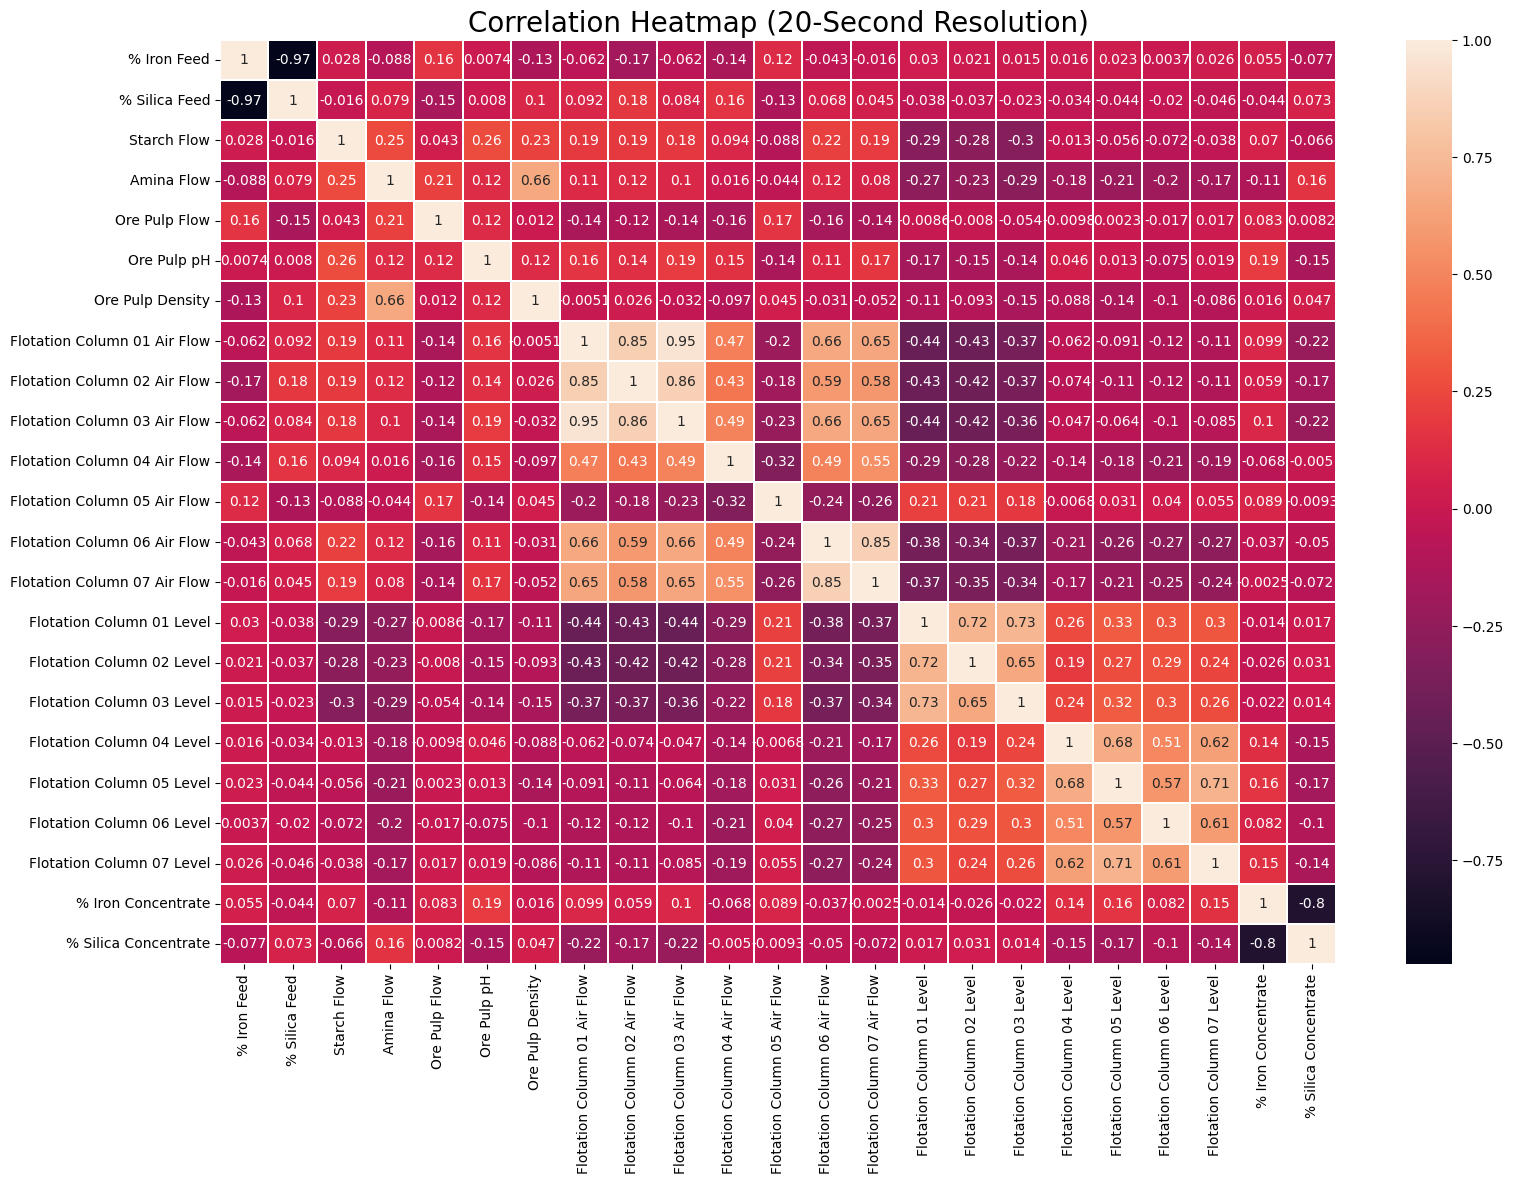

In [10]:
# --- 20-second correlations ---
plt.figure(figsize=(18,12))
sns.heatmap(df_20s.corr(), annot=True, linewidths=0.003)
plt.title('Correlation Heatmap (20-Second Resolution)', fontsize=20)
plt.show()

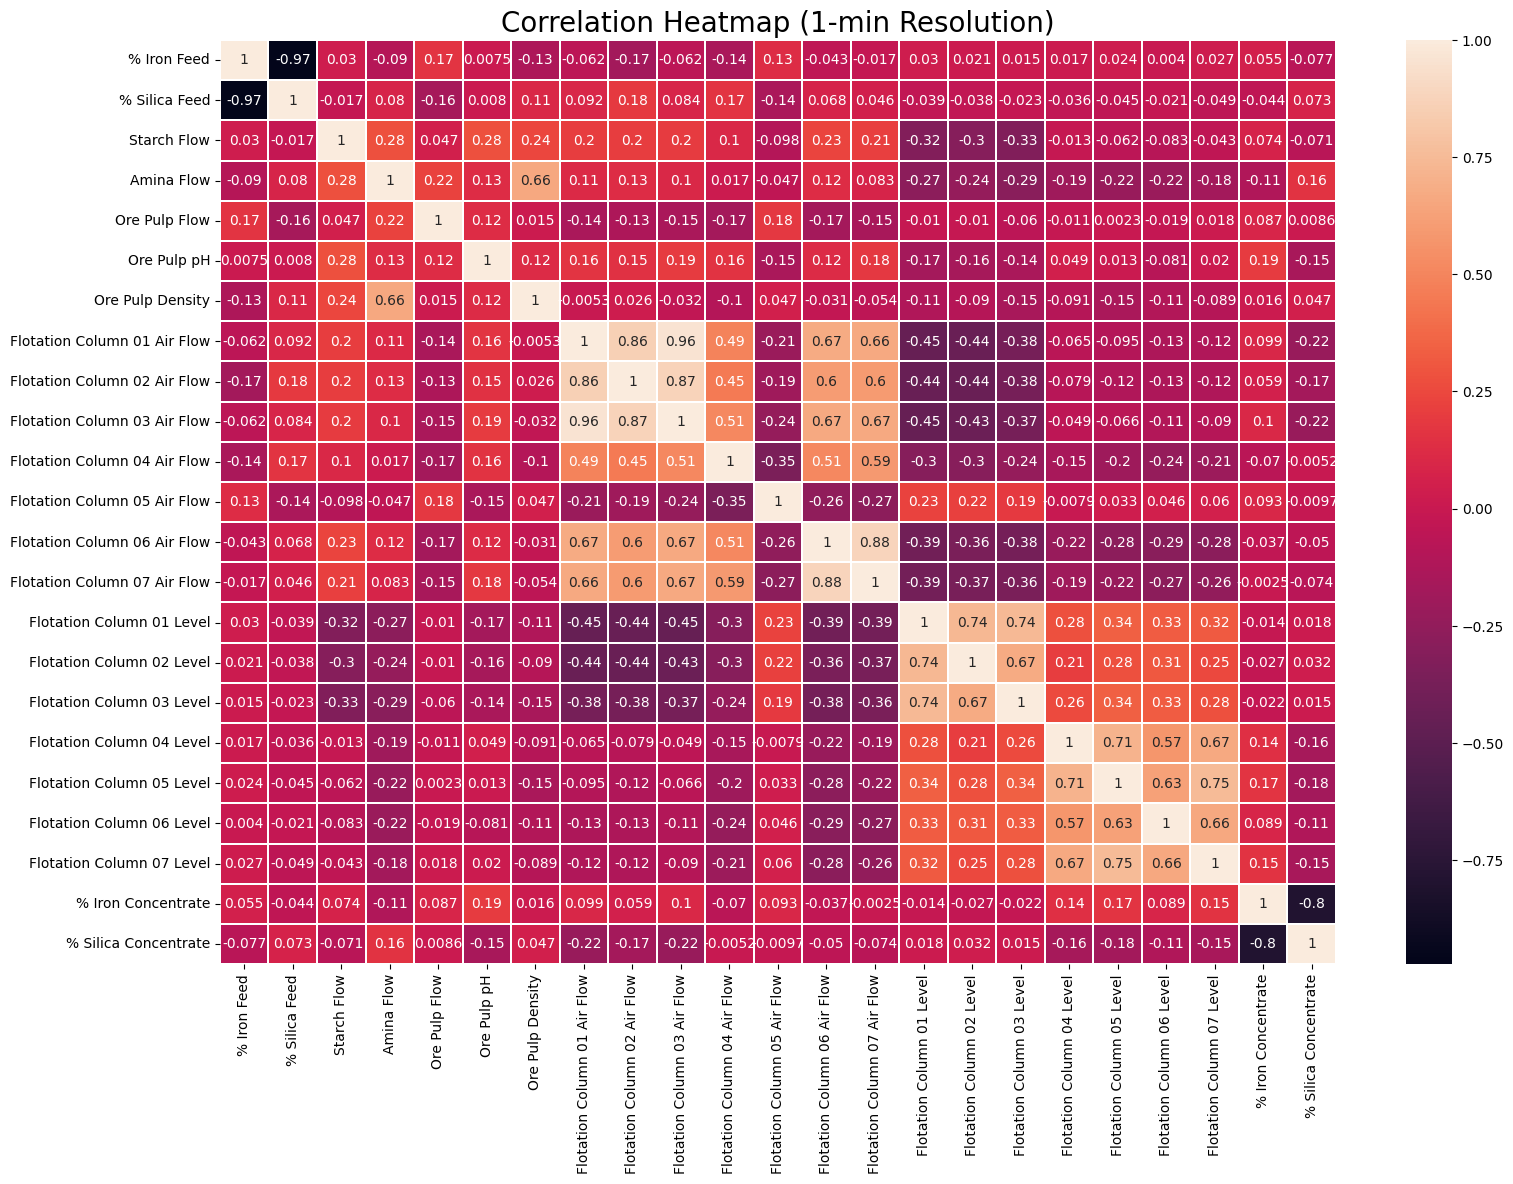

In [11]:
# --- 1-minute correlations ---
plt.figure(figsize=(18,12))
sns.heatmap(df_1min.corr(), annot=True, linewidths=0.003)
plt.title('Correlation Heatmap (1-min Resolution)', fontsize=20)
plt.show()

## 8. Target (% Silica Concentrate) Continuity Assesment
**Should see a visible gap this time because NaN has been filled in for missing timestamps** 

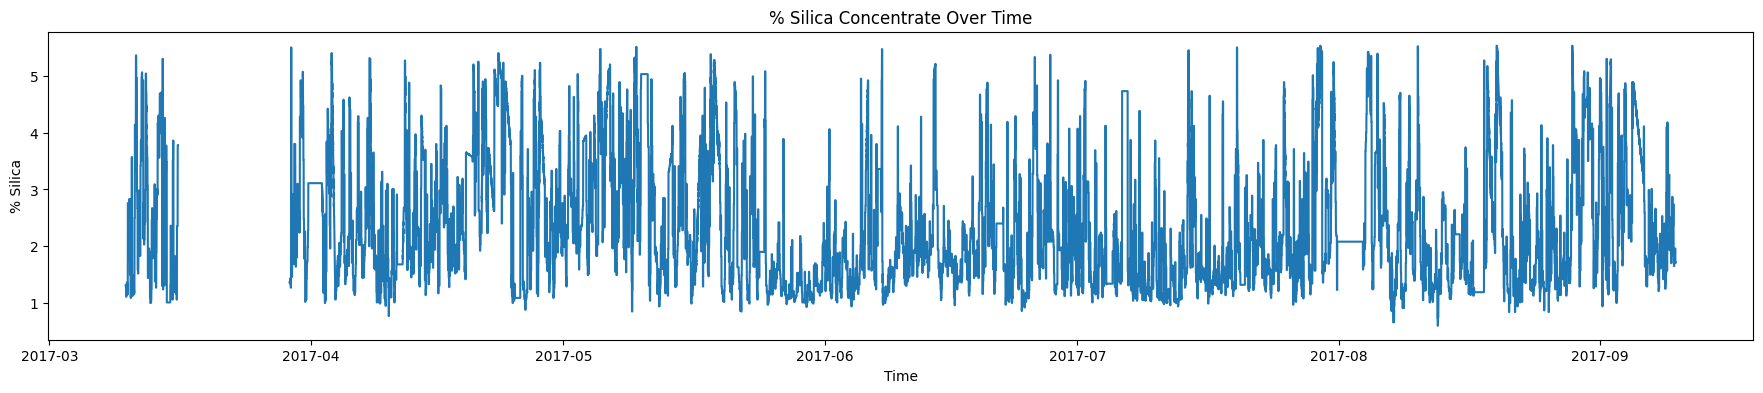

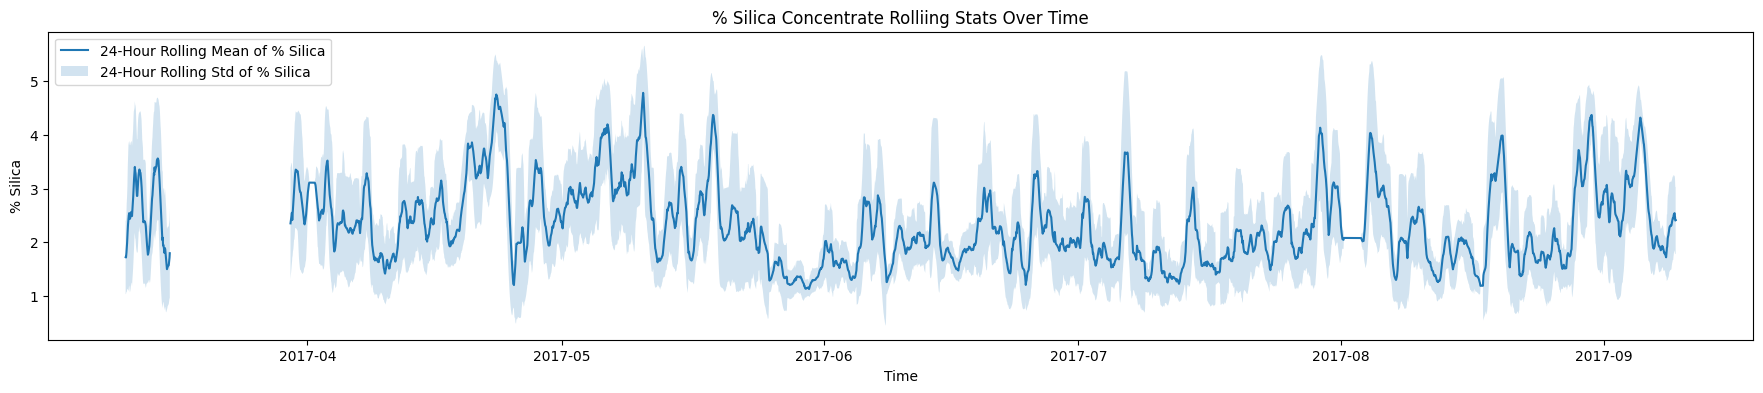

In [12]:
# Plot time trend
silica_over_time = df_1min['% Silica Concentrate']
plt.figure(figsize=(22,4))
plt.plot(silica_over_time.index, silica_over_time)
plt.title('% Silica Concentrate Over Time')
plt.xlabel('Time')
plt.ylabel('% Silica')
plt.show()

# Apply Rolling Statistics
rolling_window = 60*24 # one day rolling window
silica_rolling_mean = silica_over_time.rolling(window=rolling_window, center=True).mean()
silica_rolling_std = silica_over_time.rolling(window=rolling_window, center=True).std()

# Plot time trend will rolling stats
plt.figure(figsize=(22,4))
plt.plot(silica_rolling_mean.index, silica_rolling_mean, label='24-Hour Rolling Mean of % Silica')
plt.fill_between(silica_rolling_std.index, silica_rolling_mean - silica_rolling_std, silica_rolling_mean + silica_rolling_std, alpha=0.2, label='24-Hour Rolling Std of % Silica')
plt.title('% Silica Concentrate Rolliing Stats Over Time')
plt.xlabel('Time')
plt.ylabel('% Silica')
plt.legend()
plt.show()

## 9. Frequency Distributions

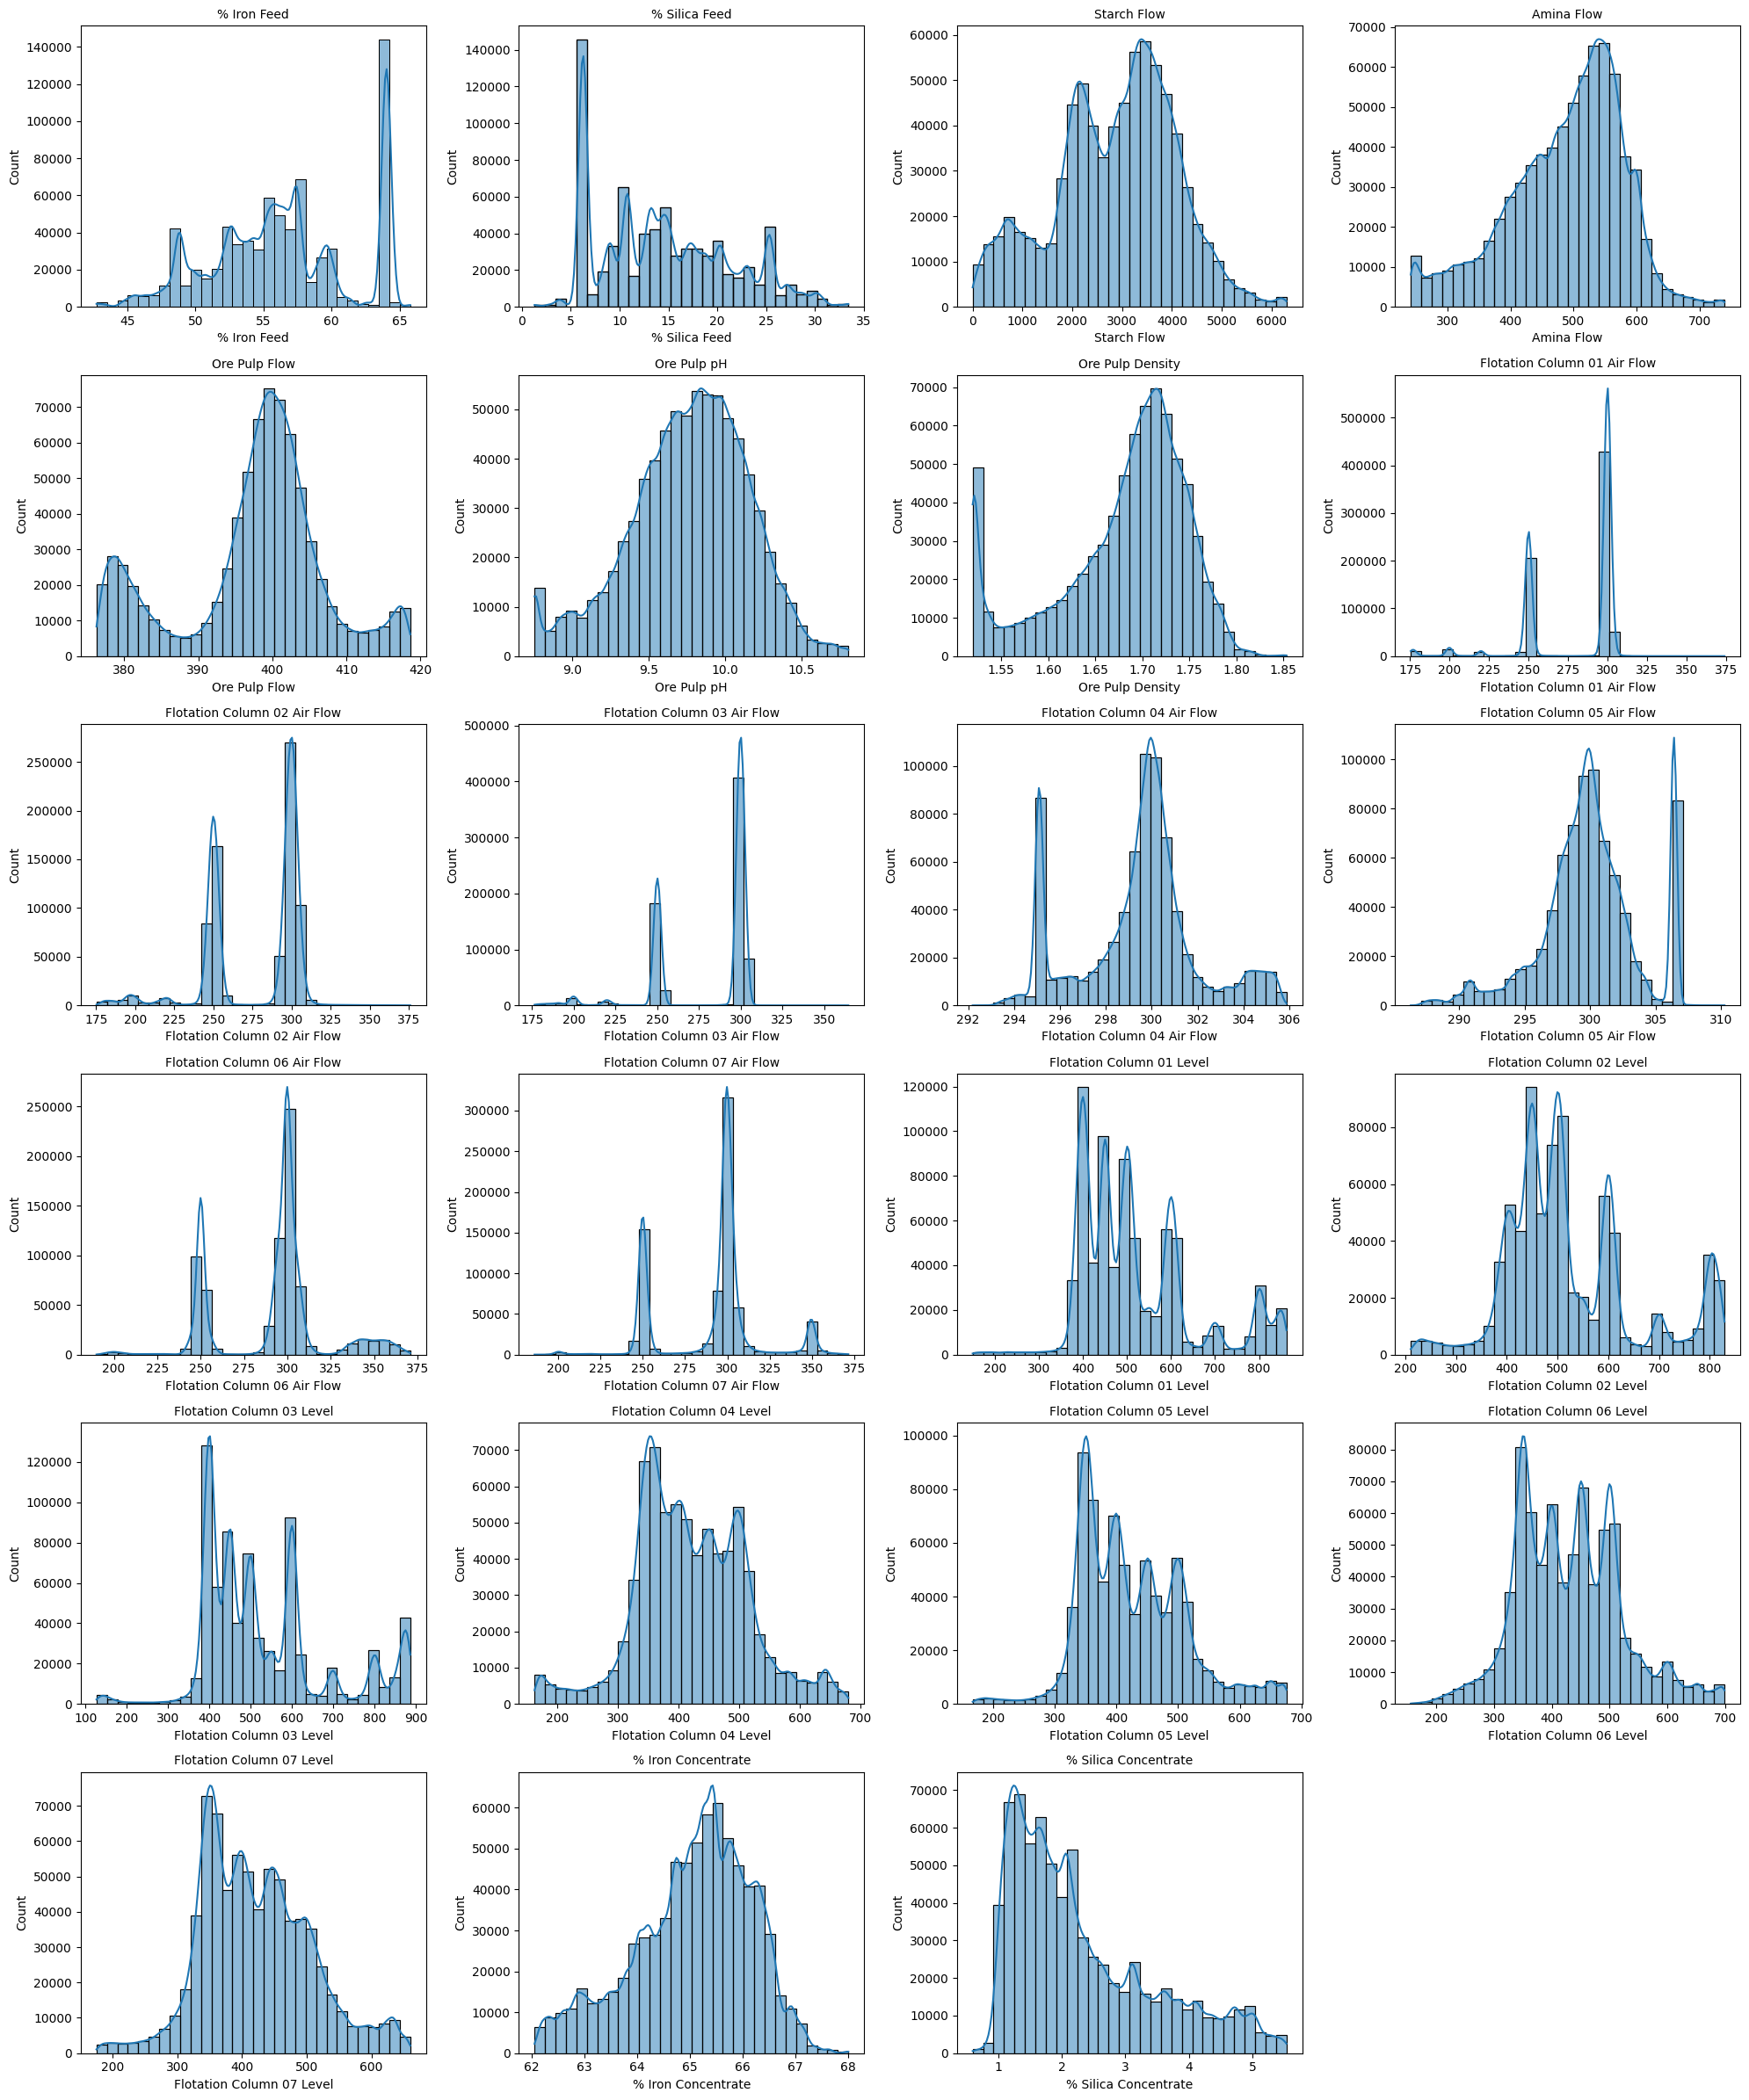

In [13]:
# Select only numeric columns (ignores timestamp + categorical)
num_cols = df_mining.select_dtypes(include=[np.number]).columns

# Layout (adjust as needed)
n_cols = 4
n_rows = int(np.ceil(len(num_cols) / n_cols))

plt.figure(figsize=(20, 4 * n_rows))

for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df_mining[col], bins=30, kde=True)
    # plt.hist(df_mining[col], bins=50, alpha=0.7)
    plt.title(col, fontsize=10)
    plt.tight_layout()

plt.show()

---
# III. Baseline Model
This section trains and test our baseline (Linear Regression) model

## 1. Train + Test Split Helpers

In [ ]:
# Training on first 85% of time series and test on rest 15%
train_85_test_15_split = SoftSensorPipeline.train_85_test_15_split

# Training on first row of every hour block (as recommended by Professor & TA)
train_1_test_59_split = SoftSensorPipeline.train_1_test_59_split

## 2. Baseline Training & Results

In [ ]:
train_test_on_baseline_model = SoftSensorPipeline.train_test_on_baseline_model

train_test_on_baseline_model(df_1min, train_85_test_15_split, False)


Baseline Linear Regression Results:
MAPE: 37.57%
R²:   0.0298
MAE:  0.9031


---
# IV. Feature Engineering

This section covers addition of new features in order to help predictions. Both Hour-Level and Minute-Level features were added very carefully without introducing any data leaks. Date leaking is very easy with this dataset because there are reapeating targets for many rows. We also added calendar features

In [ ]:
df_all_features = SoftSensorPipeline.make_features(df_1min)

---
# V. ML Pipeline for Hyperparameter Grid Search

Elasticnet, Lightgbm and Catboost were used here because they don't reequire consistent temporal structure and are able to treat every row independently (this includes freature engineered entries in the row for temporal context)

## 1. Build models + param grids

In [ ]:
# class CatBoostRegressorSK(_CatBoostRegressor, BaseEstimator, RegressorMixin):
#     """Thin sklearn-compatible wrapper around CatBoostRegressor."""
#     pass

CatBoostRegressorSK = soft_sensor_lib.CatBoostRegressorSK
# ---------------------------------------------------
# Helper: build models + param grids
# ---------------------------------------------------

make_models = SoftSensorPipeline.make_models

## 2. Hyperparameter search + evaluation

In [ ]:
# ---------------------------------------------------
# Helper: run hyperparameter search + evaluation
# ---------------------------------------------------
tune_and_evaluate_models = SoftSensorPipeline.tune_and_evaluate_models

## 3. Model Comparisons Method

In [ ]:
# ---------------------------------------------------
# Orchestrator: one call
# ---------------------------------------------------
run_model_comparison = SoftSensorPipeline.run_model_comparison

## 4. Run Model Comparison (85-15 split)

In [24]:
results1, summary1 = run_model_comparison(df_all_features, train_85_test_15_split, folds=3, n_jobs=2, debug=False)

Models:   0%|          | 0/3 [00:00<?, ?it/s]


===== Tuning ElasticNet =====
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best params for ElasticNet: {'model__alpha': 0.05, 'model__l1_ratio': 0.9}
ElasticNet Test MAPE: 0.2252
ElasticNet Test R²:   0.6471
ElasticNet Test MAE:  0.5064
ElasticNet Time:      00:15

===== Tuning CatBoost =====
Fitting 3 folds for each of 16 candidates, totalling 48 fits


Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric perio

Best params for CatBoost: {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'n_estimators': 300}
CatBoost Test MAPE: 0.1973
CatBoost Test R²:   0.6249
CatBoost Test MAE:  0.4863
CatBoost Time:      04:12

===== Tuning LightGBM =====
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END model__alpha=0.01, model__l1_ratio=0.1;, score=-0.337 total time=   1.2s
[CV 3/3] END model__alpha=0.01, model__l1_ratio=0.1;, score=-0.224 total time=   3.5s
[CV 1/3] END model__alpha=0.01, model__l1_ratio=0.9;, score=-0.332 total time=   0.5s
[CV 3/3] END model__alpha=0.01, model__l1_ratio=0.9;, score=-0.217 total time=   0.8s
[CV 2/3] END model__alpha=0.05, model__l1_ratio=0.1;, score=-0.246 total time=   0.8s
[CV 1/3] END model__alpha=0.05, model__l1_ratio=0.5;, score=-0.332 total time=   0.3s
[CV 3/3] END model__alpha=0.05, model__l1_ratio=0.5;, score=-0.217 total time=   0.5s
[CV 2/3] END model__alpha=0.05, model__l1_ratio=0.9;, score=-0.251 total time=   0.3s
[CV 1/3] END mod

,model,best_params,test_MAPE,test_R2,test_MAE,tune_train_time,folds
0,ElasticNet,"{'model__alpha': 0.05, 'model__l1_ratio': 0.9}",0.225236,0.647129,0.506389,00:15,3
1,CatBoost,"{'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'n_estimators': 300}",0.197333,0.624898,0.486320,04:12,3
2,LightGBM,"{'learning_rate': 0.05, 'n_estimators': 500, 'num_leaves': 63}",0.239534,0.604433,0.549446,07:51,3


([{'model': 'ElasticNet',
   'best_params': {'model__alpha': 0.05, 'model__l1_ratio': 0.9},
   'test_MAPE': 0.2252358543550722,
   'test_R2': 0.6471294221853829,
   'test_MAE': 0.5063894211867991,
   'best_estimator': Pipeline(steps=[('scaler', StandardScaler()),
                   ('model',
                    ElasticNet(alpha=0.05, l1_ratio=0.9, max_iter=5000,
                               random_state=42))]),
   'tune_train_time': '00:15',
   'folds': 3},
  {'model': 'CatBoost',
   'best_params': {'depth': 6,
    'l2_leaf_reg': 3,
    'learning_rate': 0.03,
    'n_estimators': 300},
   'test_MAPE': 0.19733289814878982,
   'test_R2': 0.6248975366203857,
   'test_MAE': 0.486320305291023,
   'best_estimator': CatBoostRegressorSK(depth=6, l2_leaf_reg=3, learning_rate=0.03,
                       loss_function='MAE', n_estimators=300, random_seed=42,
                       task_type='GPU', verbose=False),
   'tune_train_time': '04:12',
   'folds': 3},
  {'model': 'LightGBM',
   'best_pa

## 5. Run Model Comparison (1-59 split as per Professor & TA recommendation)

In [28]:
results2, summary2 = run_model_comparison(df_all_features, train_1_test_59_split, folds=3, n_jobs=2, debug=False)

Models:   0%|          | 0/3 [00:00<?, ?it/s]


===== Tuning ElasticNet =====
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best params for ElasticNet: {'model__alpha': 0.01, 'model__l1_ratio': 0.9}
ElasticNet Test MAPE: 0.2205
ElasticNet Test R²:   0.6316
ElasticNet Test MAE:  0.4676
ElasticNet Time:      00:02

===== Tuning CatBoost =====
Fitting 3 folds for each of 16 candidates, totalling 48 fits


Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric perio

Best params for CatBoost: {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'n_estimators': 300}
CatBoost Test MAPE: 0.1748
CatBoost Test R²:   0.6602
CatBoost Test MAE:  0.4058
CatBoost Time:      05:21

===== Tuning LightGBM =====
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END model__alpha=0.01, model__l1_ratio=0.1;, score=-0.269 total time=   0.0s
[CV 3/3] END model__alpha=0.01, model__l1_ratio=0.1;, score=-0.213 total time=   0.0s
[CV 1/3] END model__alpha=0.01, model__l1_ratio=0.9;, score=-0.258 total time=   0.0s
[CV 2/3] END model__alpha=0.01, model__l1_ratio=0.9;, score=-0.252 total time=   0.0s
[CV 3/3] END model__alpha=0.01, model__l1_ratio=0.9;, score=-0.209 total time=   0.0s
[CV 3/3] END model__alpha=0.05, model__l1_ratio=0.1;, score=-0.214 total time=   0.0s
[CV 3/3] END model__alpha=0.05, model__l1_ratio=0.5;, score=-0.213 total time=   0.0s
[CV 2/3] END model__alpha=0.05, model__l1_ratio=0.9;, score=-0.260 total time=   0.0s
[CV 1/3] END mod

,model,best_params,test_MAPE,test_R2,test_MAE,tune_train_time,folds
0,ElasticNet,"{'model__alpha': 0.01, 'model__l1_ratio': 0.9}",0.220511,0.631556,0.467640,00:02,3
1,CatBoost,"{'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'n_estimators': 300}",0.174800,0.660185,0.405805,05:21,3
2,LightGBM,"{'learning_rate': 0.05, 'n_estimators': 500, 'num_leaves': 63}",0.108877,0.910942,0.229273,03:47,3


## 6. Analysis of results

The 85–15 split represents true forward-in-time generalization, so the models score in a reasonable range (MAPE ~0.19–0.24, R² ~0.60–0.65). This reflects the actual difficulty of predicting silica across different months and operating regimes. When switching to the recommended 1–59 split, performance improves for all models, but LightGBM in particular shows a dramatic jump (MAPE ~0.11, R² ~0.91). This reflects how the task being evaluated is different: under the 1–59 split, the model is not forecasting into the future but interpolating within the same hour, where the target (% Silica Concentrate) is constant for all 60 minutes blocks. Because the test samples come from the same hour as a training sample, the learning problem becomes far easier and variance in the target collapses, inflating R².

So while the 1–59 split results are valid for assessing a “soft sensor” that fills in the 59 minutes between hourly lab samples, they should not be interpreted as long-term predictive accuracy. The 85–15 results better represent forecasting difficulty, whereas the 1–59 results represent interpolation accuracy. LightGBM’s very strong scores arise from the structure of the data and the easier evaluation setting, not from suspicious behavior.
